In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec

import warnings
warnings.filterwarnings("ignore")

In [3]:
data_folder = "data"

all_marketing_data = pd.read_csv(f"{data_folder}/marketing_data.csv", parse_dates=["Week"])
all_chat_sessions = pd.read_csv(f"{data_folder}/chat_sessions.csv", parse_dates=["event_time", "user_first_chat"])
all_worktime_schedule = pd.read_csv(f"{data_folder}/worktime_schedule_data.csv", parse_dates=["event_time"])

In [4]:
display(all_marketing_data.head())
display(all_chat_sessions.head())
display(all_worktime_schedule.head())

Week Expected spend     Fact spend
0 2025-04-28    $827,050.00    $737,606.00
1 2025-05-05    $896,000.00  $1,144,046.49
2 2025-05-12    $952,000.00  $1,171,861.46
3 2025-05-19    $952,000.00  $1,513,413.95
4 2025-05-26    $892,500.00  $1,291,209.25

session_id   user_id  expert_id  \
0  6f157276-25fd-49de-a39e-30a8c6d85430  21221614       1354   
1  9c1479a7-e68e-4ff5-89cc-5eac83a87e25  35973273       1978   
2  52b555fa-73d5-4fe0-881e-691f696ceb6b  35907515        964   
3  ef1c8116-af23-4221-a440-21235e7fda57  35934794       2103   
4  a2a4fa34-1067-4829-91a8-f88e990c1813  36247623       1660   

           event_time  session_duration     user_first_chat  
0 2025-01-13 05:19:22         15.333333 2024-10-12 04:59:13  
1 2025-01-15 00:30:06          0.983333 2025-01-15 00:30:06  
2 2025-01-11 14:03:42          5.016667 2025-01-11 14:03:42  
3 2025-01-13 21:05:40          3.183333 2025-01-13 21:05:40  
4 2025-01-19 12:03:02          2.533333 2025-01-19 12:03:02

event_time  specialist_astrocrm_user_id  online_worktime_duration  \
0 2025-01-11 10:00:00                         1102                  0.073083   
1 2025-01-11 10:00:00                         1272                 26.696617   
2 2025-01-11 10:00:00                         1281                 36.005783   
3 2025-01-11 10:00:00                         1478                 19.091367   
4 2025-01-11 10:00:00                         1559                 35.236700   

   busy_worktime_duration  scheduled_duration  force_busy_duration  
0               33.937683                 0.0            33.937767  
1                3.525617                 0.0             0.000000  
2                0.000000                 0.0             0.000000  
3                1.182017                 0.0             0.000000  
4                0.000000                 0.0             0.000000

In [5]:
all_chat_sessions.drop_duplicates(subset=["session_id", "user_id", "expert_id"], inplace=True)

In [6]:
data_threshold = all_marketing_data[all_marketing_data['Fact spend'].isna()]['Week'].min()

marketing_data_predictive = all_marketing_data[all_marketing_data['Week'] >= data_threshold].copy()
marketing_data = all_marketing_data[all_marketing_data['Week'] < data_threshold].copy()

chat_sessions_predictive = all_chat_sessions[all_chat_sessions['event_time'] >= data_threshold].copy()
assert chat_sessions_predictive.empty, "Chat sessions found for impossible date."
chat_sessions = all_chat_sessions[all_chat_sessions['event_time'] < data_threshold].copy()

worktime_schedule_predictive = all_worktime_schedule[all_worktime_schedule['event_time'] >= data_threshold].copy()
worktime_schedule = all_worktime_schedule[all_worktime_schedule['event_time'] < data_threshold].copy()

In [7]:
chat_sessions["weekday"] = chat_sessions["event_time"].dt.day_name()
chat_sessions["hour"] = chat_sessions["event_time"].dt.hour

display(chat_sessions.head())

session_id   user_id  expert_id  \
0  6f157276-25fd-49de-a39e-30a8c6d85430  21221614       1354   
1  9c1479a7-e68e-4ff5-89cc-5eac83a87e25  35973273       1978   
2  52b555fa-73d5-4fe0-881e-691f696ceb6b  35907515        964   
3  ef1c8116-af23-4221-a440-21235e7fda57  35934794       2103   
4  a2a4fa34-1067-4829-91a8-f88e990c1813  36247623       1660   

           event_time  session_duration     user_first_chat    weekday  hour  
0 2025-01-13 05:19:22         15.333333 2024-10-12 04:59:13     Monday     5  
1 2025-01-15 00:30:06          0.983333 2025-01-15 00:30:06  Wednesday     0  
2 2025-01-11 14:03:42          5.016667 2025-01-11 14:03:42   Saturday    14  
3 2025-01-13 21:05:40          3.183333 2025-01-13 21:05:40     Monday    21  
4 2025-01-19 12:03:02          2.533333 2025-01-19 12:03:02     Sunday    12

In [8]:
def plot_chat_sessions_overview(chat_sessions, description=None):
    days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    
    # Ensure required datetime components
    chat_sessions = chat_sessions.copy()
    chat_sessions['date'] = chat_sessions['event_time'].dt.date
    chat_sessions['weekday'] = chat_sessions['event_time'].dt.day_name()
    chat_sessions['hour'] = chat_sessions['event_time'].dt.hour
    chat_sessions['week'] = chat_sessions['event_time'].dt.isocalendar().week

    weeks = sorted(chat_sessions['week'].unique())
    n_weeks = len(weeks)

    # Layout: sizes
    n_cols_week = 4
    n_rows_week = int(np.ceil(n_weeks / n_cols_week))

    n_cols_hourly = 3
    n_rows_hourly = int(np.ceil(n_weeks / n_cols_hourly))

    # Total height based on number of rows
    total_height = 5 + (n_rows_week * 4) + (n_rows_hourly * 4) + 5

    fig = plt.figure(constrained_layout=False, figsize=(26, total_height))

    # GridSpec: Overall layout
    n_total_rows = 1 + n_rows_week + n_rows_hourly + 1  # first is overall trend, last is hourly by weekday
    spec = GridSpec(nrows=n_total_rows, ncols=1, figure=fig, height_ratios=[5] + [4]*n_rows_week + [4]*n_rows_hourly + [5])

    # 1. Overall daily trend
    ax0 = fig.add_subplot(spec[0, 0])
    chat_sessions['date'].value_counts().sort_index().plot(ax=ax0)
    ax0.set_title('Chat Sessions Over Time', fontsize=16)
    ax0.set_xlabel('Date', fontsize=14)
    ax0.set_ylabel('Number of Sessions', fontsize=14)
    ax0.tick_params(axis='x', rotation=45)

    # 2. Daily distribution per week
    for idx in range(n_weeks):
        row = 1 + idx // n_cols_week
        col = idx % n_cols_week
        inner_spec = GridSpec(n_total_rows, n_cols_week, figure=fig)
        ax = fig.add_subplot(inner_spec[row, col])
        week_data = chat_sessions[chat_sessions['week'] == weeks[idx]]
        sns.countplot(
            data=week_data,
            x='weekday',
            order=days,
            ax=ax,
            palette='viridis'
        )
        ax.set_title(f'Week {weeks[idx]}', fontsize=10)
        ax.set_xlabel('Day')
        ax.tick_params(axis='x', rotation=45)
        if col == 0:
            ax.set_ylabel('Sessions')
        else:
            ax.set_ylabel('')

    # 3. Hourly (hue by hour) per weekday per week
    for idx in range(n_weeks):
        row = 1 + n_rows_week + idx // n_cols_hourly
        col = idx % n_cols_hourly
        inner_spec = GridSpec(n_total_rows, n_cols_hourly, figure=fig)
        ax = fig.add_subplot(inner_spec[row, col])
        week_data = chat_sessions[chat_sessions['week'] == weeks[idx]]
        sns.countplot(
            data=week_data,
            x='weekday',
            hue='hour',
            order=days,
            ax=ax,
            palette='viridis',
            dodge=True
        )
        ax.set_title(f'Week {weeks[idx]} (Hour Hue)', fontsize=10)
        ax.set_xlabel('Day')
        ax.set_xticks(range(len(days)))
        ax.set_xticklabels(days, rotation=45)
        if col == 0:
            ax.set_ylabel('Sessions')
        else:
            ax.set_ylabel('')
        ax.legend(
            title='Hour', loc='upper right', fontsize='x-small',
            title_fontsize='x-small', frameon=False, ncol=2, bbox_to_anchor=(1, 1)
        )

    # 4. Hourly distribution for each weekday → moved to the end
    inner_spec = spec[-1, 0].subgridspec(1, 7)
    for i, day in enumerate(days):
        ax = fig.add_subplot(inner_spec[0, i])
        sns.countplot(
            data=chat_sessions[chat_sessions['weekday'] == day],
            x='hour',
            ax=ax,
            palette='viridis'
        )
        ax.set_title(day, fontsize=10)
        ax.set_xlabel('Hour')
        if i == 0:
            ax.set_ylabel('Sessions')
        else:
            ax.set_ylabel('')
        ax.set_xticks(range(0, 24, 4))
        ax.set_xticklabels(range(0, 24, 4), rotation=90)

    fig.suptitle(f'Chat Session Patterns Overview{": " + description if description else ""}', fontsize=20)
    plt.tight_layout(h_pad=3)
    plt.subplots_adjust(top=0.97, hspace=0.6)
    plt.show()

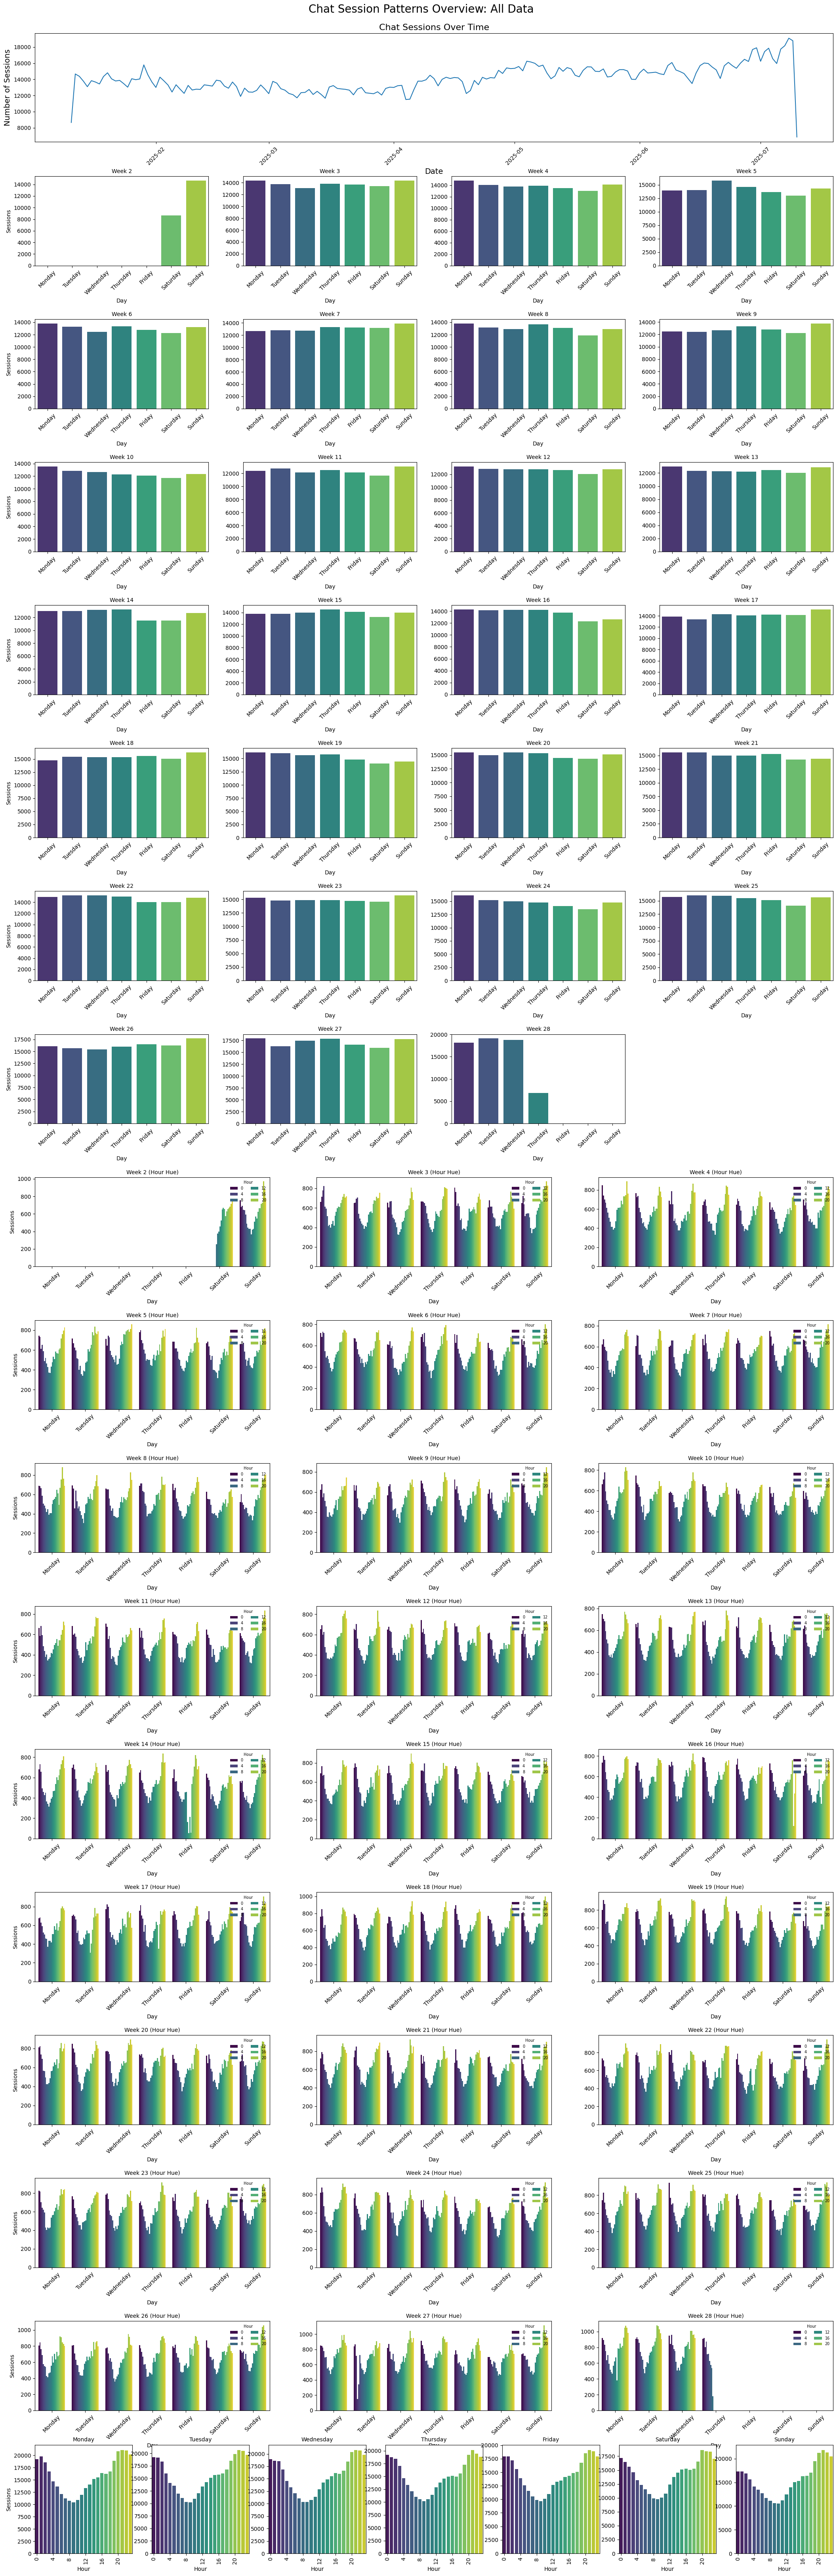

In [9]:
plot_chat_sessions_overview(chat_sessions, description="All Data")

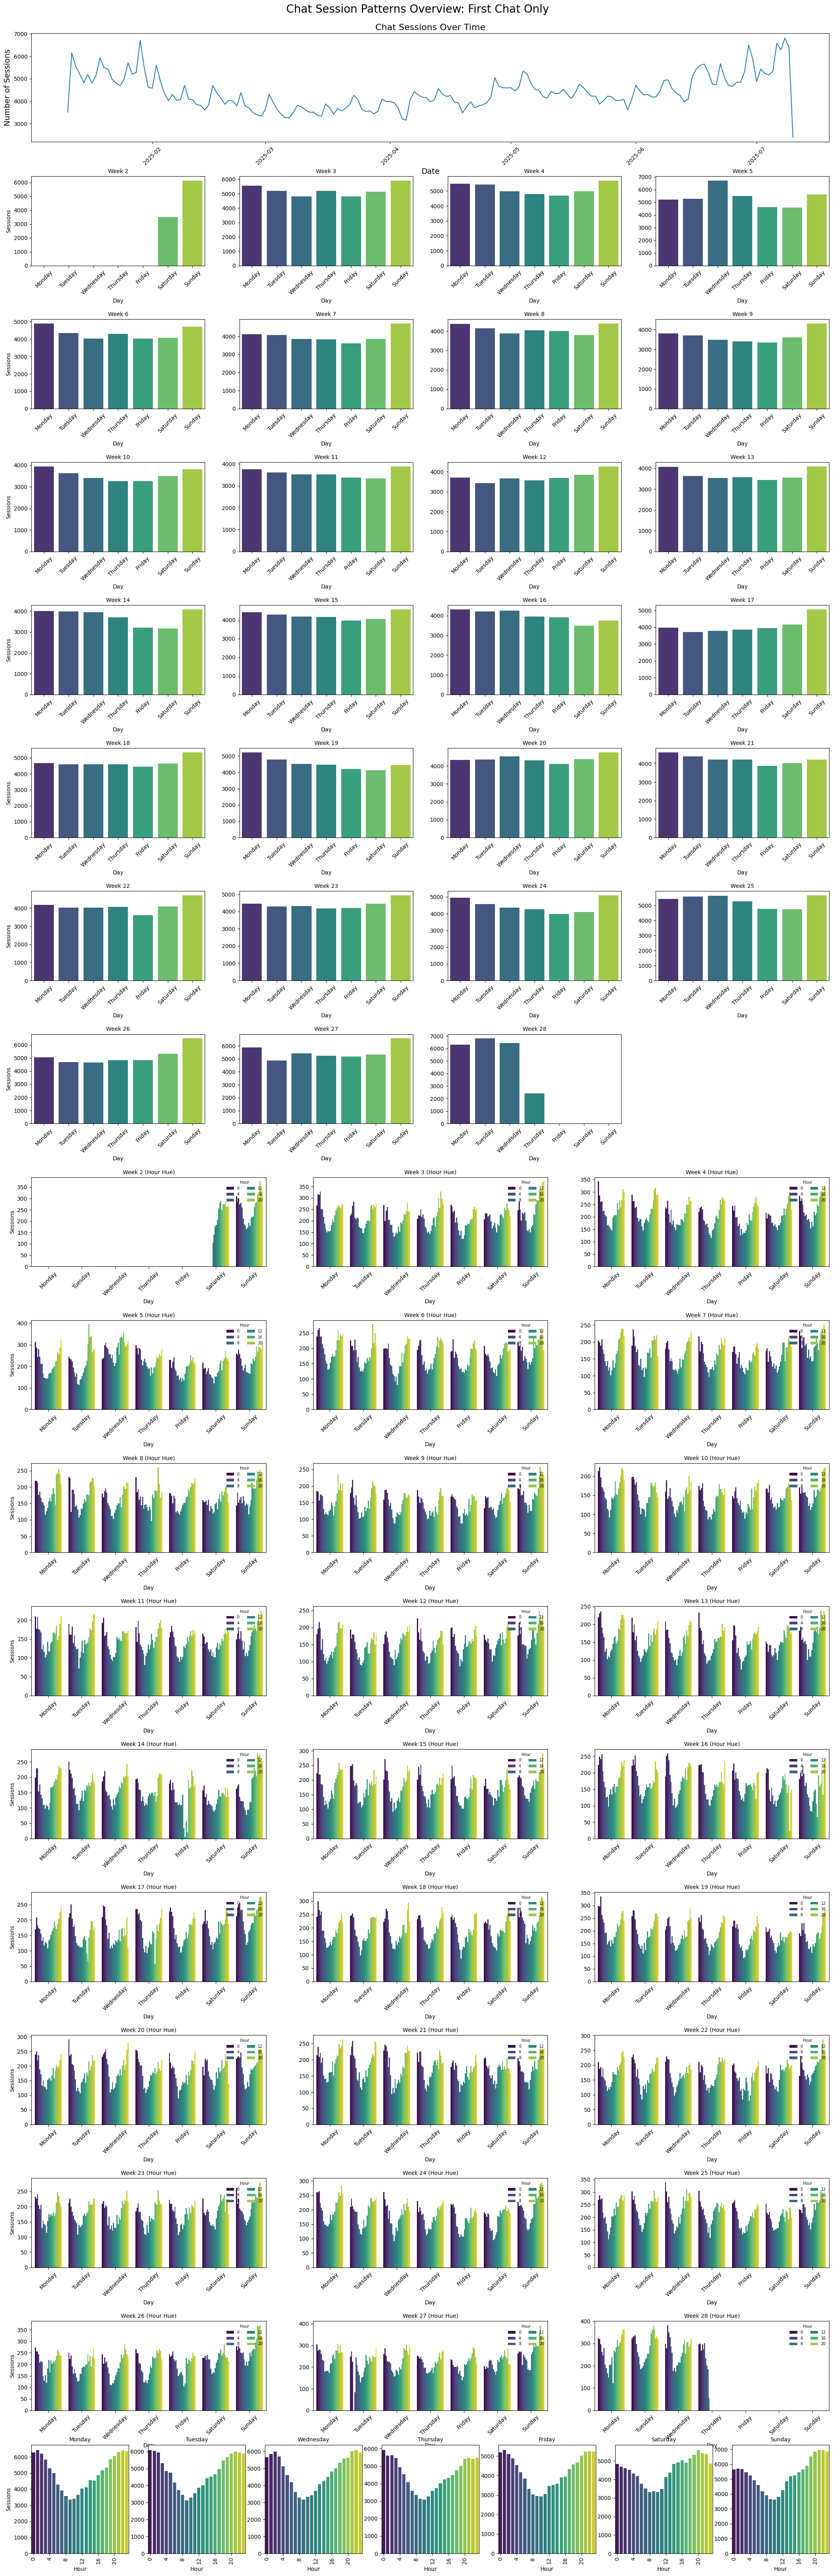

In [10]:
plot_chat_sessions_overview(chat_sessions[chat_sessions['event_time'] == chat_sessions['user_first_chat']], description="First Chat Only")

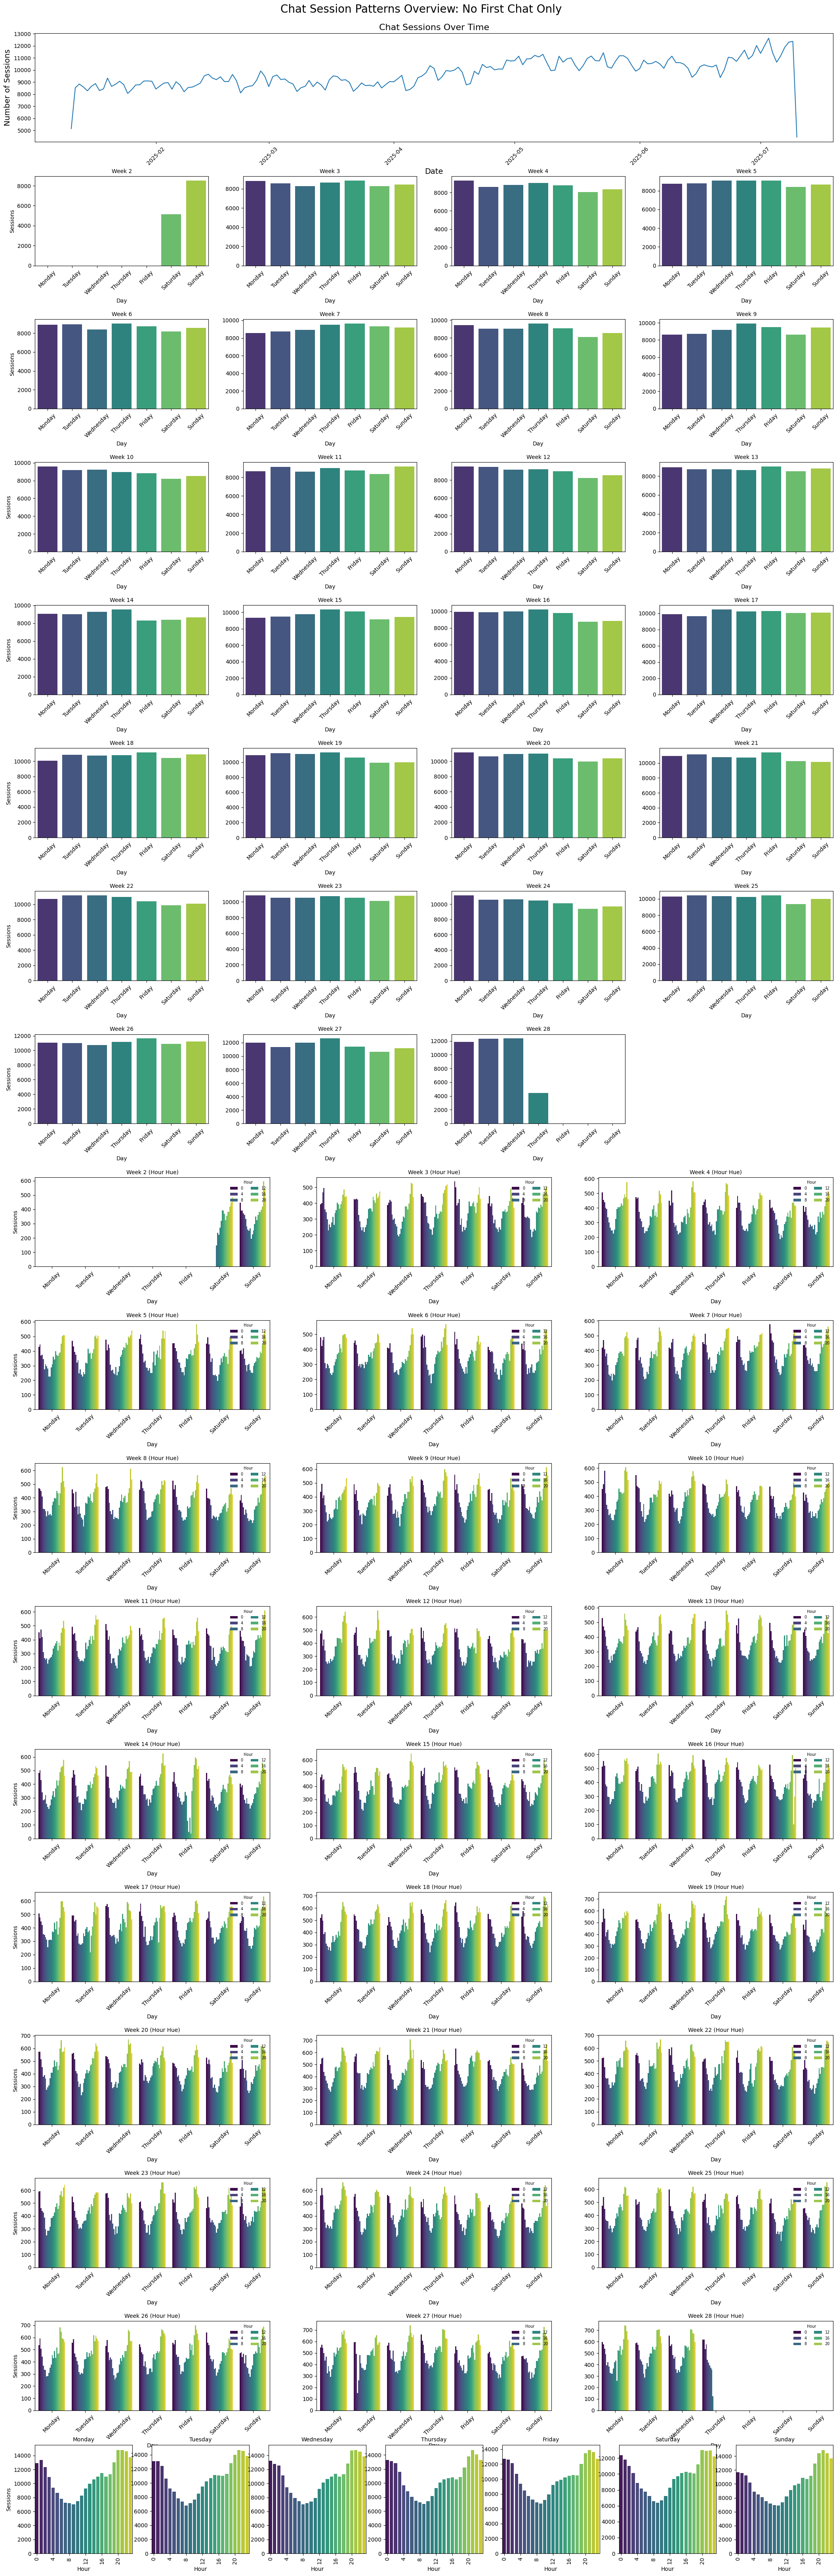

In [11]:
plot_chat_sessions_overview(chat_sessions[chat_sessions['event_time'] != chat_sessions['user_first_chat']], description="No First Chat Only")

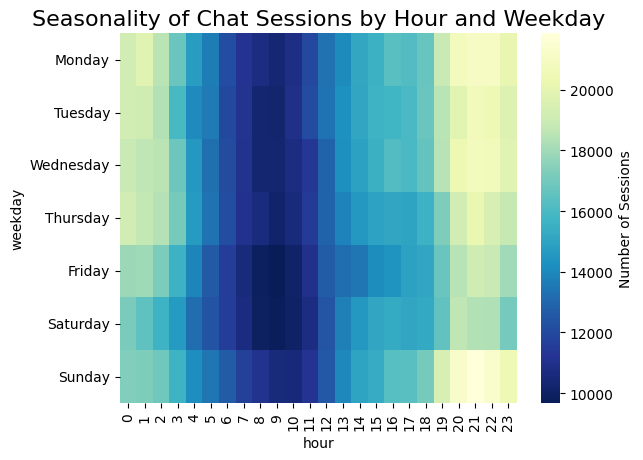

In [12]:
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
seasonality = chat_sessions.groupby(['weekday', 'hour']).size().unstack(fill_value=0)
seasonality = seasonality.reindex(index=days, columns=range(24), fill_value=0)
sns.heatmap(seasonality, cmap='YlGnBu_r', annot=False, cbar_kws={'label': 'Number of Sessions'})
plt.title('Seasonality of Chat Sessions by Hour and Weekday', fontsize=16)
plt.show()

In [18]:
def plot_worktime_schedule_overview(df, description=None):
    df = df.copy()
    df['event_time'] = pd.to_datetime(df['event_time'])
    df['date'] = df['event_time'].dt.date
    df['weekday'] = df['event_time'].dt.day_name()
    df['hour'] = df['event_time'].dt.hour
    df['week'] = df['event_time'].dt.isocalendar().week

    days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    weeks = sorted(df['week'].unique())
    n_weeks = len(weeks)

    # Layout sizes
    n_cols_week = 4
    n_rows_week = int(np.ceil(n_weeks / n_cols_week))

    n_cols_hourly = 3
    n_rows_hourly = int(np.ceil(n_weeks / n_cols_hourly))

    total_height = 5 + (n_rows_week * 4) + (n_rows_hourly * 4) + 5
    fig = plt.figure(constrained_layout=False, figsize=(26, total_height))
    n_total_rows = 1 + n_rows_week + n_rows_hourly + 1
    spec = GridSpec(nrows=n_total_rows, ncols=1, figure=fig, height_ratios=[5] + [4]*n_rows_week + [4]*n_rows_hourly + [5])

    # 1. Overall scheduled vs actual busy + online time over time
    ax0 = fig.add_subplot(spec[0, 0])
    trend = df.groupby('date')[['online_worktime_duration', 'busy_worktime_duration', 'scheduled_duration']].sum()
    trend.plot(ax=ax0)
    ax0.set_title('Total Worktime Trend Over Time', fontsize=16)
    ax0.set_ylabel('Minutes')
    ax0.set_xlabel('Date')
    ax0.tick_params(axis='x', rotation=45)

    # 2. Daily total durations (stacked) per week
    for idx in range(n_weeks):
        row = 1 + idx // n_cols_week
        col = idx % n_cols_week
        inner_spec = GridSpec(n_total_rows, n_cols_week, figure=fig)
        ax = fig.add_subplot(inner_spec[row, col])
        week_data = df[df['week'] == weeks[idx]]
        day_sum = week_data.groupby('weekday')[['scheduled_duration', 'online_worktime_duration', 'busy_worktime_duration', 'force_busy_duration']].sum()
        day_sum = day_sum.reindex(days)  # consistent order

        day_sum.plot(kind='bar', stacked=True, ax=ax, color=sns.color_palette('Set2', 4))
        ax.set_title(f'Week {weeks[idx]} — Daily Durations', fontsize=10)
        ax.set_xlabel('Day')
        ax.tick_params(axis='x', rotation=45)
        if col == 0:
            ax.set_ylabel('Minutes')
        else:
            ax.set_ylabel('')
        ax.legend().set_visible(False)

    # 3. Per-week heatmap: avg hour × weekday × total worktime
    for idx in range(n_weeks):
        row = 1 + n_rows_week + idx // n_cols_hourly
        col = idx % n_cols_hourly
        inner_spec = GridSpec(n_total_rows, n_cols_hourly, figure=fig)
        ax = fig.add_subplot(inner_spec[row, col])
        week_data = df[df['week'] == weeks[idx]].copy()
        week_data['total_worktime'] = (
            week_data['online_worktime_duration'] +
            week_data['busy_worktime_duration']
        )
        heat = week_data.groupby(['weekday', 'hour'])['total_worktime'].mean().unstack()
        heat = heat.reindex(index=days)

        sns.heatmap(heat, ax=ax, cmap='viridis')
        ax.set_title(f'Week {weeks[idx]} — Avg Worktime Heatmap', fontsize=10)
        ax.set_xlabel('Hour')
        ax.set_ylabel('Weekday')

    # 4. Hourly distribution for each weekday → barplot
    inner_spec = spec[-1, 0].subgridspec(1, 7)
    for i, day in enumerate(days):
        ax = fig.add_subplot(inner_spec[0, i])
        day_data = df[df['weekday'] == day].copy()
        day_data['total_worktime'] = (
            day_data['online_worktime_duration'] +
            day_data['busy_worktime_duration']
        )
        sns.barplot(
            data=day_data,
            x='hour',
            y='total_worktime',
            estimator='sum',
            ax=ax,
            color='teal'
        )
        ax.set_title(day, fontsize=10)
        ax.set_xlabel('Hour')
        if i == 0:
            ax.set_ylabel('Total Worktime')
        else:
            ax.set_ylabel('')
        ax.set_xticks(range(0, 24, 4))
        ax.set_xticklabels(range(0, 24, 4), rotation=90)

    fig.suptitle(f'Worktime Schedule Overview{": " + description if description else ""}', fontsize=20)
    plt.tight_layout(h_pad=3)
    plt.subplots_adjust(top=0.97, hspace=0.6)
    plt.show()

In [20]:
worktime_schedule.head()

event_time  specialist_astrocrm_user_id  online_worktime_duration  \
0 2025-01-11 10:00:00                         1102                  0.073083   
1 2025-01-11 10:00:00                         1272                 26.696617   
2 2025-01-11 10:00:00                         1281                 36.005783   
3 2025-01-11 10:00:00                         1478                 19.091367   
4 2025-01-11 10:00:00                         1559                 35.236700   

   busy_worktime_duration  scheduled_duration  force_busy_duration  
0               33.937683                 0.0            33.937767  
1                3.525617                 0.0             0.000000  
2                0.000000                 0.0             0.000000  
3                1.182017                 0.0             0.000000  
4                0.000000                 0.0             0.000000

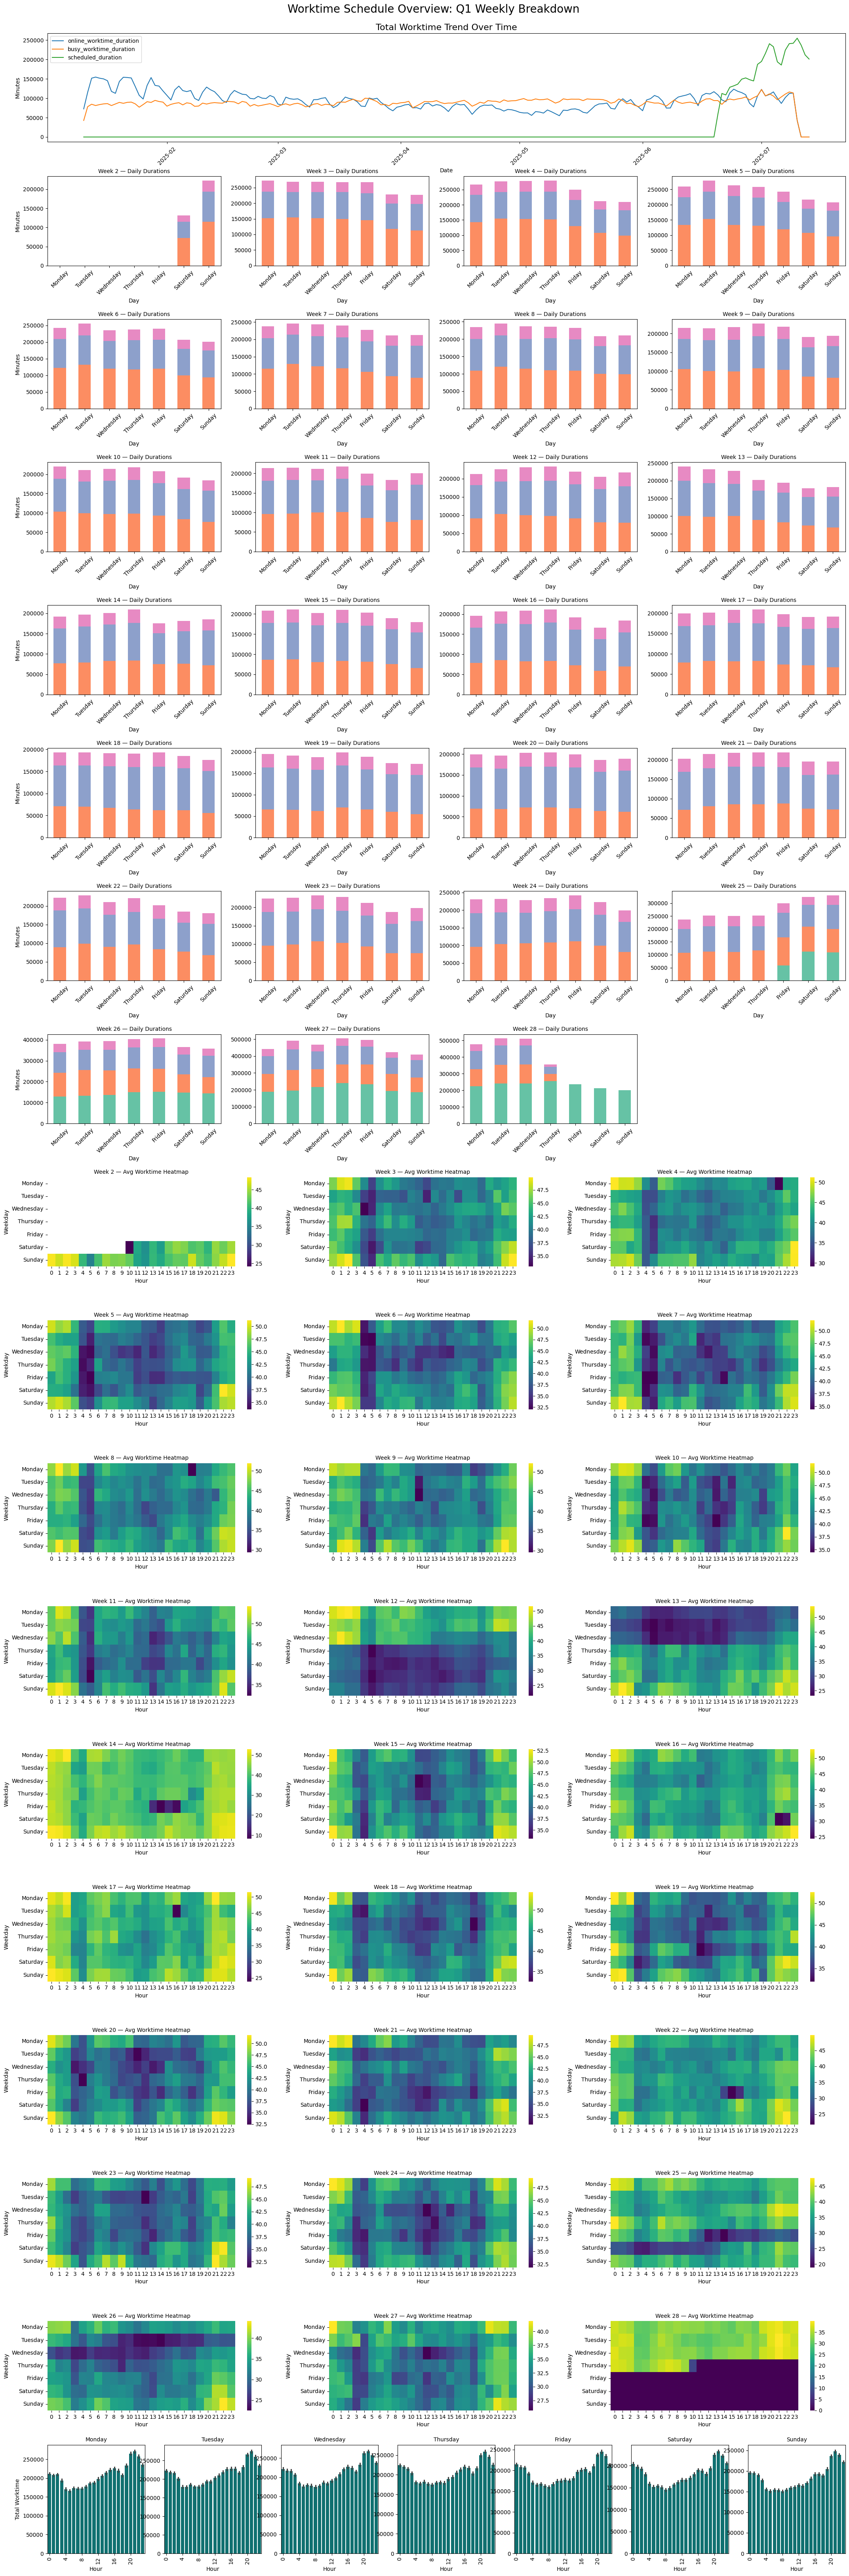

In [19]:
plot_worktime_schedule_overview(worktime_schedule, description="Q1 Weekly Breakdown")

In [21]:
def plot_chat_vs_worktime(chat_sessions, worktime_schedule, description=None):
    """
    Plots chat sessions and supplier worktime over time to compare demand vs supply.
    
    Parameters:
    - chat_sessions: DataFrame with 'event_time' column (chat timestamps)
    - worktime_schedule: DataFrame with 'event_time' and worktime duration columns
    - description: Optional title extension
    """
    # Prepare chat sessions
    chat_df = chat_sessions.copy()
    chat_df['event_time'] = pd.to_datetime(chat_df['event_time'])
    chat_df['date'] = chat_df['event_time'].dt.date
    chat_counts = chat_df.groupby('date').size().rename('chat_sessions')

    # Prepare worktime
    work_df = worktime_schedule.copy()
    work_df['event_time'] = pd.to_datetime(work_df['event_time'])
    work_df['date'] = work_df['event_time'].dt.date
    work_df['total_worktime'] = (
        work_df['online_worktime_duration'] +
        work_df['busy_worktime_duration'] +
        work_df['force_busy_duration']
    )
    worktime_daily = work_df.groupby('date')['total_worktime'].sum().rename('total_worktime_minutes')

    # Merge into one DataFrame
    combined = pd.concat([chat_counts, worktime_daily], axis=1).fillna(0)

    # Normalize for dual axis (optional)
    max_chats = combined['chat_sessions'].max()
    max_work = combined['total_worktime_minutes'].max()
    scale_ratio = max_work / max_chats if max_chats > 0 else 1
    combined['chat_sessions_scaled'] = combined['chat_sessions'] * scale_ratio

    # Plot
    fig, ax1 = plt.subplots(figsize=(20, 6))

    sns.lineplot(data=combined, x=combined.index, y='total_worktime_minutes', ax=ax1, label='Total Worktime (min)', color='teal')
    ax1.set_ylabel("Total Supplier Worktime (minutes)", color='teal')
    ax1.tick_params(axis='y', labelcolor='teal')

    # Second y-axis for chat sessions
    ax2 = ax1.twinx()
    sns.lineplot(data=combined, x=combined.index, y='chat_sessions', ax=ax2, label='Chat Sessions', color='darkorange')
    ax2.set_ylabel("Chat Sessions", color='darkorange')
    ax2.tick_params(axis='y', labelcolor='darkorange')

    # Common formatting
    ax1.set_title(f"Chat Demand vs Supplier Worktime Over Time{': ' + description if description else ''}", fontsize=16)
    ax1.set_xlabel("Date")
    ax1.tick_params(axis='x', rotation=45)
    fig.tight_layout()
    fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.95))
    plt.show()


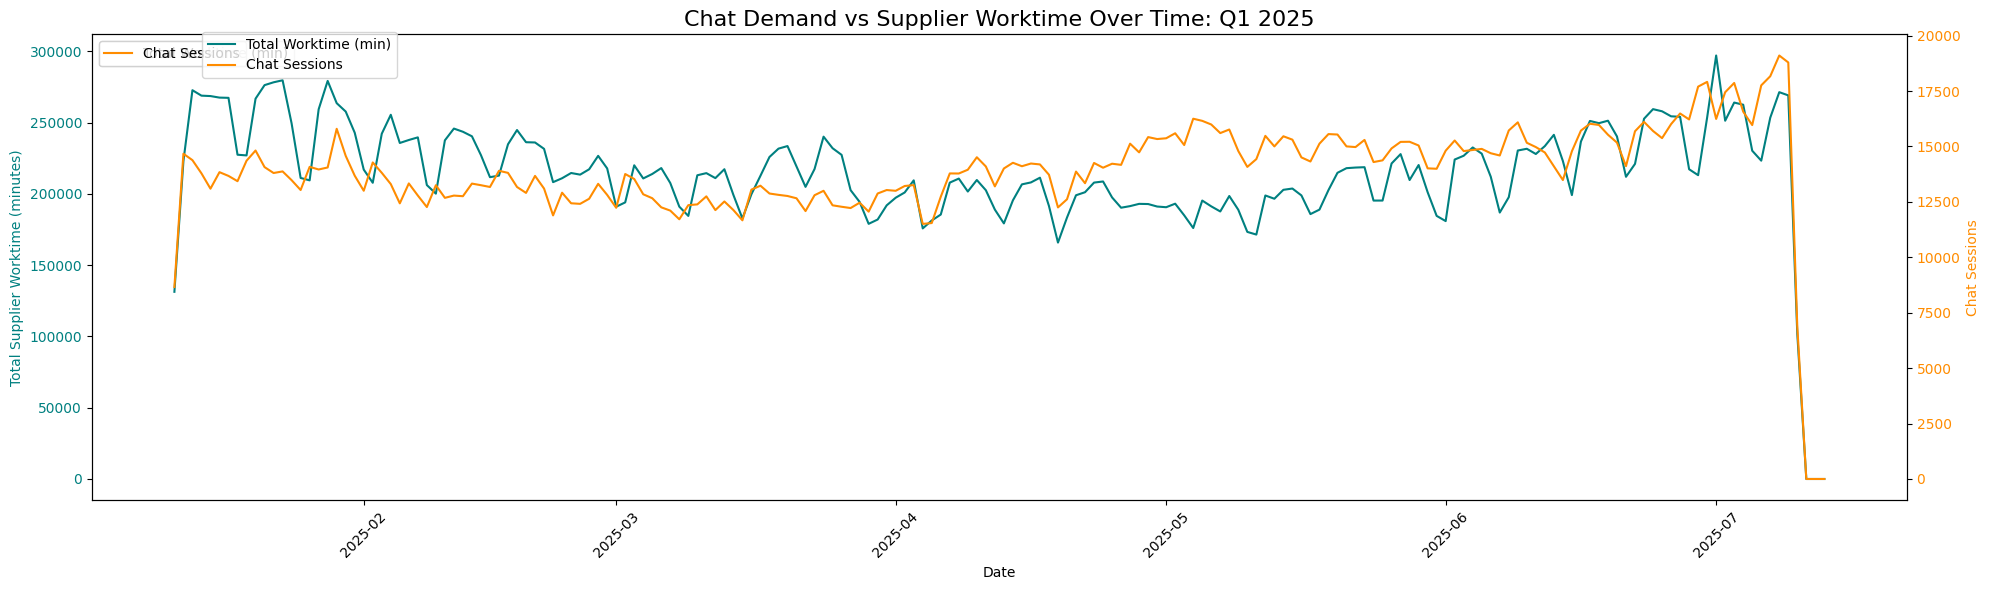

In [22]:
plot_chat_vs_worktime(chat_sessions, worktime_schedule, description="Q1 2025")

In [23]:
def plot_chat_vs_expert_count(chat_sessions, worktime_schedule, description=None):
    """
    Plots number of unique experts available vs number of chat sessions per day.
    
    Parameters:
    - chat_sessions: DataFrame with 'event_time'
    - worktime_schedule: DataFrame with 'event_time' and 'specialist_astrocrm_user_id'
    - description: Optional text to include in the title
    """
    # Prepare chat data
    chat_df = chat_sessions.copy()
    chat_df['event_time'] = pd.to_datetime(chat_df['event_time'])
    chat_df['date'] = chat_df['event_time'].dt.date
    chat_counts = chat_df.groupby('date').size().rename('chat_sessions')

    # Prepare expert count
    work_df = worktime_schedule.copy()
    work_df['event_time'] = pd.to_datetime(work_df['event_time'])
    work_df['date'] = work_df['event_time'].dt.date

    # Count number of distinct experts per day who have *any* worktime that day
    expert_counts = (
        work_df.groupby('date')['specialist_astrocrm_user_id']
        .nunique()
        .rename('experts_online')
    )

    # Merge
    combined = pd.concat([chat_counts, expert_counts], axis=1).fillna(0)

    # Normalize for dual-axis plotting
    max_chats = combined['chat_sessions'].max()
    max_experts = combined['experts_online'].max()
    scale_ratio = max_experts / max_chats if max_chats > 0 else 1
    combined['chat_sessions_scaled'] = combined['chat_sessions'] * scale_ratio

    # Plot
    fig, ax1 = plt.subplots(figsize=(20, 6))

    sns.lineplot(
        data=combined,
        x=combined.index,
        y='experts_online',
        ax=ax1,
        label='Experts Online (count)',
        color='seagreen'
    )
    ax1.set_ylabel("Experts Online", color='seagreen')
    ax1.tick_params(axis='y', labelcolor='seagreen')

    # Second axis: chat sessions (raw count)
    ax2 = ax1.twinx()
    sns.lineplot(
        data=combined,
        x=combined.index,
        y='chat_sessions',
        ax=ax2,
        label='Chat Sessions',
        color='darkorange'
    )
    ax2.set_ylabel("Chat Sessions", color='darkorange')
    ax2.tick_params(axis='y', labelcolor='darkorange')

    # Final touches
    ax1.set_title(f"Chat Demand vs Expert Supply (by Headcount){': ' + description if description else ''}", fontsize=16)
    ax1.set_xlabel("Date")
    ax1.tick_params(axis='x', rotation=45)
    fig.tight_layout()
    fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.95))
    plt.show()


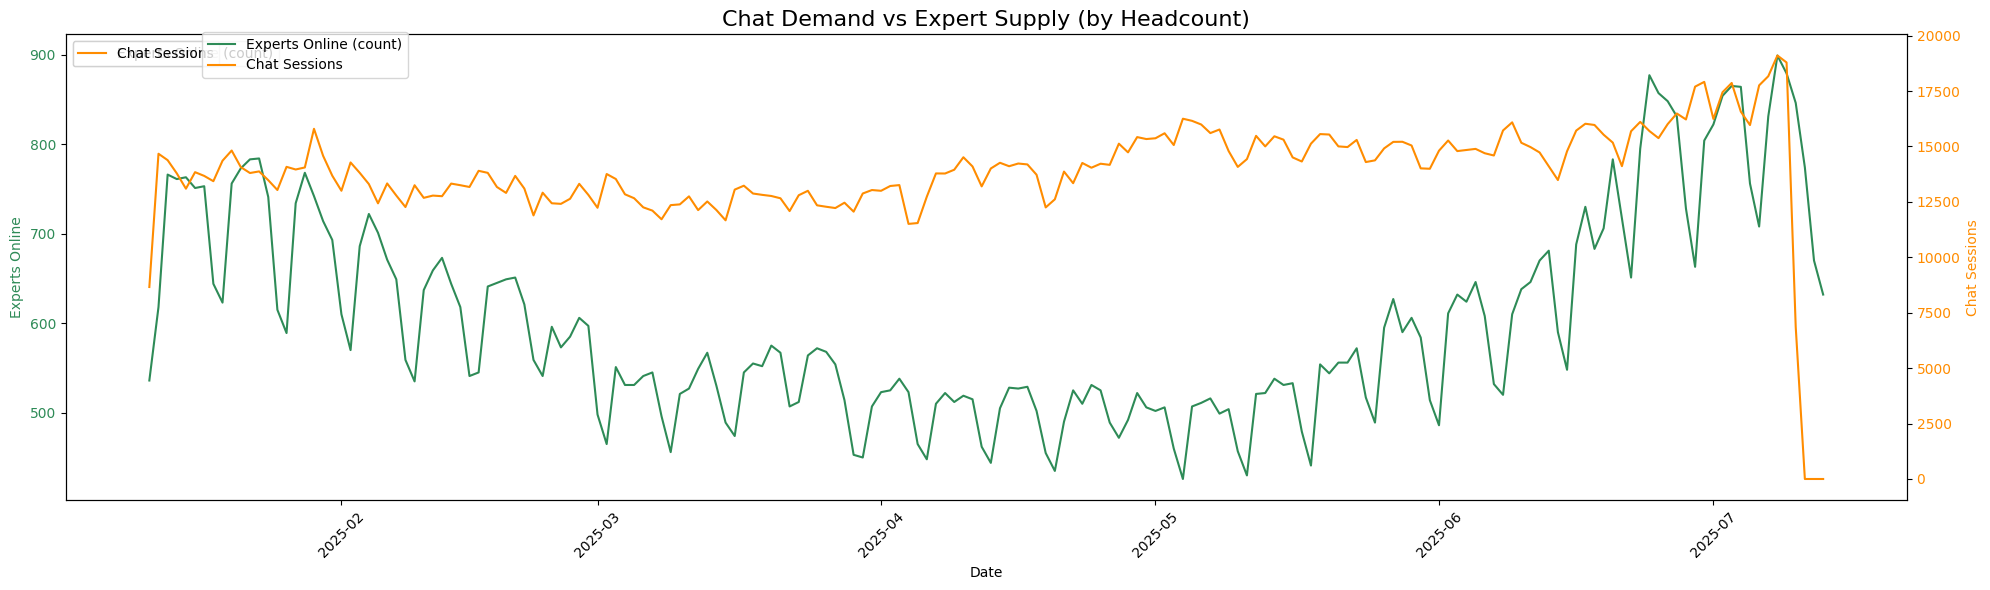

In [24]:
plot_chat_vs_expert_count(chat_sessions, worktime_schedule)